# 필독
---
**코딩 테스트 응시 방법**  
본 파일은 배포용으로, 사본을 만들어 문제 풀이를 진행해주세요.  

**평가 관련**  
문제 해결 능력을 중심으로 평가합니다.  
구현 시, 예제와 같은 구성을 따를 필요는 없습니다.  
필요없다 생각하는 부분을 덜거나, 필요하다 생각하는 부분들을 추가하셔도 됩니다. 완전히 구조가 달라도 상관 없습니다.  

 만일 구현에 실패한 부분이 있다면 무엇을 구현하고자 했지만 실패했는지, 구현 의도와 실패한 코드를 남겨주세요.  

**제출 양식**
- 제목 : [코딩 테스트/단계]이름_ 과 _학번

**구현,작업 관리 주의사항**  
아래 4가지 규칙을 지켜 구현한 코드와 보고서를 함께 제출해주신 모든 벗들과 면접을 진행할 예정입니다. 꼭 읽고 지켜주세요!

- 📍**딥러닝 프레임워크는 pytorch를 사용해주세요.**
- 📍**코드 설명을 달아주세요.**
- 📍**코드 출력을 지우지 말고 제출해주세요.**
- 📍**공유 권한을 설정해주세요.**


# MNIST DataSet에 대하여
---
MNIST dataset은 28x28 규격의 흑백 이미지 데이터 셋입니다. 이 데이터 셋은 0부터 9까지 10개의 라벨이 존재하며 이미지 학습의 대표적인 예제입니다.  
MNIST dataset은 `pytorch.vision`이나 인터넷을 통해 다운 받아 이용할 수 있습니다.

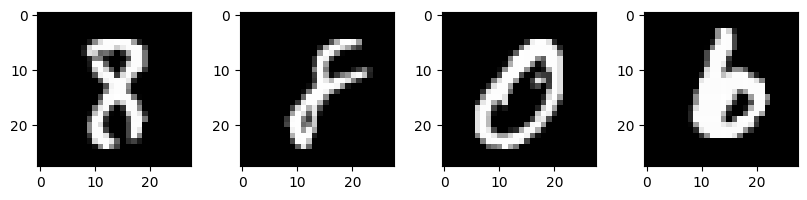

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


## 2. Load and Preprocess Data

In [3]:
# 학습 데이터와 테스트 데이터 로드
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               download=True,
                               transform=ToTensor())

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              download=True,
                              transform=ToTensor())

# train 데이터를 학습셋과 검증셋으로 분할 (8:2 비율)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# 데이터셋 크기 확인
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.58MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Training set size: 48000
Validation set size: 12000
Test set size: 10000


In [4]:
# DataLoader 설정
batch_size = 64

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

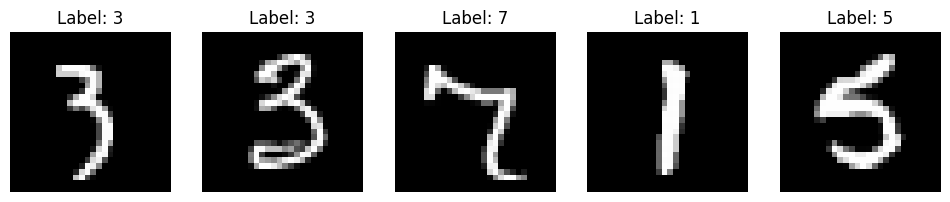

In [8]:
# 데이터 시각화 함수
def show_sample_images(loader, num_samples=5):
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
      plt.subplot(1, num_samples, i+1)
      plt.imshow(images[i].squeeze(), cmap='gray')
      plt.title(f'Label: {labels[i]}')
      plt.axis('off')
    plt.show()

# 샘플 이미지 출력
show_sample_images(train_loader)

## 3. Define Model

In [9]:
class SimpleMNISTCNN(nn.Module):
    def __init__(self):
        super(SimpleMNISTCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Second Convolutional Block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    # 순전파 정의
    def forward(self, x):
        x = self.conv1(x)     # Input: 1 x 28 x 28 -> Output: 32 x 14 x 14
        x = self.conv2(x)     # Input: 32 x 14 x 14 -> Output: 64 x 7 x 7
        x = self.fc(x)        # Input: 64 x 7 x 7 -> Output: 10
        return x

# 모델 생성 및 GPU로 이동
model = SimpleMNISTCNN().to(device)

# 모델 확인
print(model)

SimpleMNISTCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


## 4. Loss Function & Optimizer

In [10]:
# 학습 파라미터 설정
learning_rate = 0.001
num_epochs = 10

# 손실 함수 정의: Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# 옵티마이저 정의: Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 5. Training & Validation

In [11]:
# 학습 모드 정의
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 통계 업데이트
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [12]:
# 평가 모드 정의
def evaluate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

In [13]:
# 학습 기록을 위한 리스트
train_losses, train_accs = [], []
val_losses, val_accs = [], []

# 학습 시작
print("Training Started!")
print("-" * 40)

for epoch in range(num_epochs):
    # 학습
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

    # 검증
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    # 기록 저장
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # 진행상황 출력
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')
    print(f'Valid - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%')
    print("-" * 40)

Training Started!
----------------------------------------
Epoch [1/10]
Train - Loss: 0.3136, Accuracy: 90.25%
Valid - Loss: 0.0726, Accuracy: 97.74%
----------------------------------------
Epoch [2/10]
Train - Loss: 0.1080, Accuracy: 96.76%
Valid - Loss: 0.0560, Accuracy: 98.30%
----------------------------------------
Epoch [3/10]
Train - Loss: 0.0827, Accuracy: 97.55%
Valid - Loss: 0.0395, Accuracy: 98.77%
----------------------------------------
Epoch [4/10]
Train - Loss: 0.0672, Accuracy: 98.05%
Valid - Loss: 0.0375, Accuracy: 98.88%
----------------------------------------
Epoch [5/10]
Train - Loss: 0.0575, Accuracy: 98.23%
Valid - Loss: 0.0331, Accuracy: 99.03%
----------------------------------------
Epoch [6/10]
Train - Loss: 0.0509, Accuracy: 98.44%
Valid - Loss: 0.0369, Accuracy: 98.97%
----------------------------------------
Epoch [7/10]
Train - Loss: 0.0444, Accuracy: 98.66%
Valid - Loss: 0.0355, Accuracy: 99.00%
----------------------------------------
Epoch [8/10]
Trai

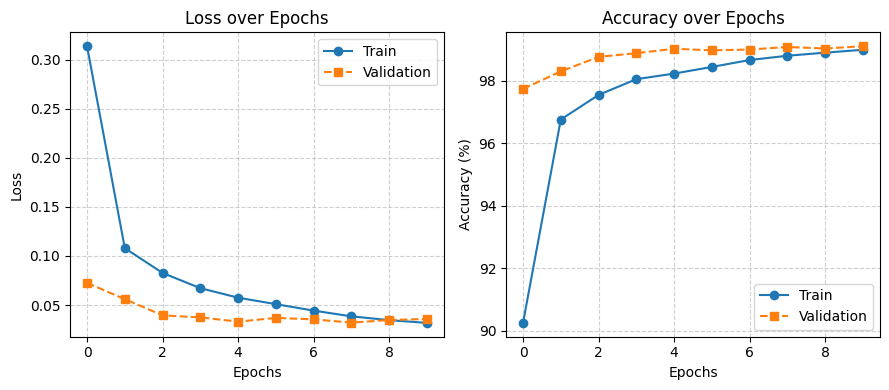

In [14]:
def training_results(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(9, 4))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train', marker='o', linestyle='-')
    plt.plot(val_losses, label='Validation', marker='s', linestyle='--')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train', marker='o', linestyle='-')
    plt.plot(val_accs, label='Validation', marker='s', linestyle='--')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# 최종 학습 결과 시각화
training_results(train_losses, val_losses, train_accs, val_accs)

## 6. Evaluate & Visualize

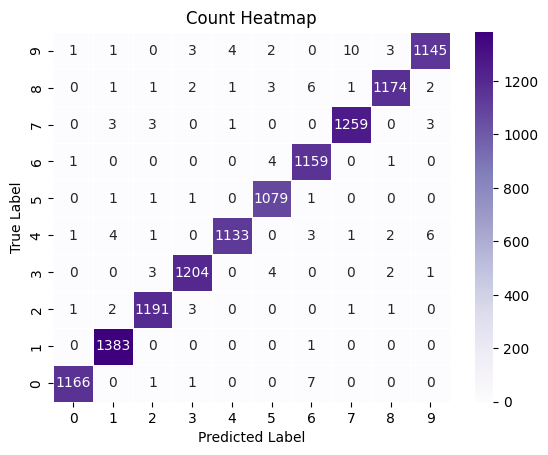

In [15]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, data_loader, classes):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            _, predicted = model(images).max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 혼동 행렬 계산 및 반전
    cm = confusion_matrix(all_labels, all_preds)[::-1, :]

    # 히트맵 시각화
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Purples', linewidths=0.5, xticklabels=classes, yticklabels=classes[::-1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Count Heatmap')
    plt.show()

# 클래스 리스트 정의
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# 히트맵 생성
plot_confusion_matrix(model, val_loader, classes)